In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to your images
base_dir = '/content/drive/MyDrive/MS 2nd Semester/AAV data/Images/175 mV/1s_segment_raw/train_val_photos'

In [ ]:
# ImageDataGenerator for preprocessing and augmentation
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)


In [ ]:
# Create generators for training and validation
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 2183 images belonging to 3 classes.
Found 545 images belonging to 3 classes.


In [ ]:
# Load the ResNet50 model (without the top classification layer)
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Function to extract features using ResNet50
def extract_features(generator, sample_count, batch_size=32):
    """
    Extracts features from images using ResNet50.

    Args:
        generator: ImageDataGenerator or tf.data.Dataset.
        sample_count (int): Total number of samples to process.
        batch_size (int): Batch size for feature extraction.

    Returns:
        features (numpy.ndarray): Extracted features.
        labels (numpy.ndarray): Corresponding labels.
    """
    # Initialize arrays to store features and labels
    features = np.zeros((sample_count, 7, 7, 2048))  # ResNet50 output shape
    labels = np.zeros((sample_count, len(generator.class_indices)))  # One-hot encoded labels

    # Process batches
    num_batches = int(np.ceil(sample_count / batch_size))
    start_idx = 0

    for i, (images_batch, labels_batch) in enumerate(generator):
        if i >= num_batches:
            break  # Stop after processing enough samples

        # Extract features for the current batch
        features_batch = model.predict(images_batch)

        # Calculate end index for the current batch
        end_idx = start_idx + len(images_batch)

        # Handle the case where the last batch is smaller than batch_size
        if end_idx > sample_count:
            end_idx = sample_count
            features_batch = features_batch[:end_idx - start_idx]
            labels_batch = labels_batch[:end_idx - start_idx]

        # Store features and labels
        features[start_idx:end_idx] = features_batch
        labels[start_idx:end_idx] = labels_batch

        # Update start index
        start_idx = end_idx

        if start_idx >= sample_count:
            break  # Stop after processing enough samples

    return features, labels

# Create ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# Create generators for training and validation
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

# Extract features for training and validation sets
train_features, train_labels = extract_features(train_generator, 2000)  # Adjust sample_count as needed
validation_features, validation_labels = extract_features(validation_generator, 800)  # Adjust sample_count as needed

# Flatten the features for SVM
train_features_flat = train_features.reshape((train_features.shape[0], -1))
validation_features_flat = validation_features.reshape((validation_features.shape[0], -1))

print("Training features shape:", train_features_flat.shape)
print("Validation features shape:", validation_features_flat.shape)

Found 2183 images belonging to 3 classes.
Found 545 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━

In [ ]:
# Flatten the features for SVM
train_features_flat = train_features.reshape((train_features.shape[0], -1))  # Shape: (num_samples, 7 * 7 * 2048)
validation_features_flat = validation_features.reshape((validation_features.shape[0], -1))  # Shape: (num_samples, 7 * 7 * 2048)

# Train the SVM classifier
svm = OneVsRestClassifier(SVC(kernel='linear', probability=True))
svm.fit(train_features_flat, train_labels)

# Predict on the validation set
predicted_labels = svm.predict(validation_features_flat)

# Evaluate the classifier
conf_matrix = confusion_matrix(np.argmax(validation_labels, axis=1), np.argmax(predicted_labels, axis=1))
accuracy = accuracy_score(np.argmax(validation_labels, axis=1), np.argmax(predicted_labels, axis=1))

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy * 100:.2f}%")

Confusion Matrix:
[[143   5  38]
 [ 18 232  39]
 [ 21  29 275]]
Accuracy: 81.25%


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Processing ResNet50...
Found 2183 images belonging to 3 classes.
Found 545 images belonging to 3 classes.
Saved ResNet50 SVM model to /ResNet50_svm.joblib
Overall Accuracy: 86.24%
Confusion Matrix:
[[192  14  12]
 [  4 289  42]
 [ 12  24 196]]
Classification Report:
              precision    recall  f1-score   support

      Double       0.92      0.88      0.90       218
       Empty       0.88      0.86      0.87       335
      Single       0.78      0.84      0.81       232

    accuracy                           0.86       785
   macro avg       0.86      0.86      0.86       785
weighted avg       0.87      0.86      0.86       785



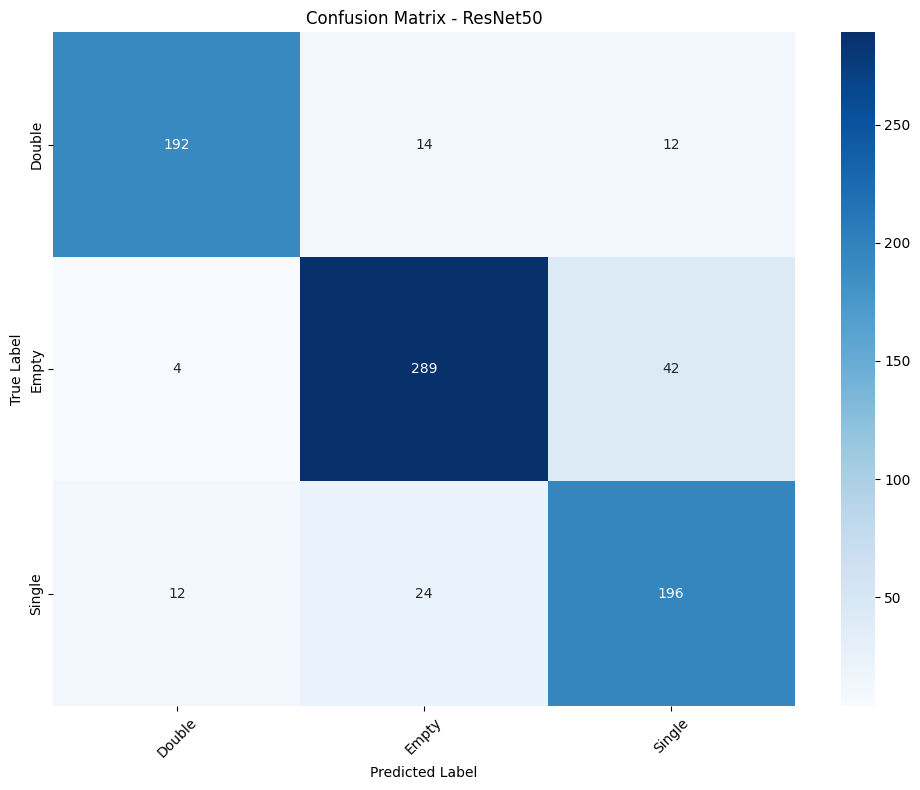

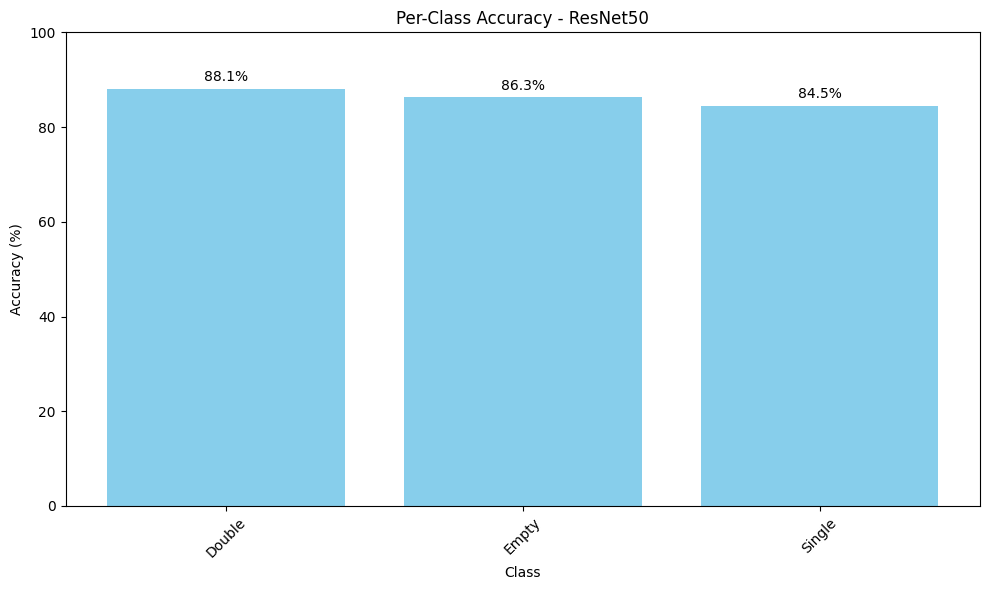


Processing VGG16...
Found 2183 images belonging to 3 classes.
Found 545 images belonging to 3 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Saved VGG16 SVM model to /VGG16_svm.joblib
Overall Accuracy: 85.61%
Confusion Matrix:
[[182  20  16]
 [  7 290  38]
 [  4  28 200]]
Classification Report:
              precision    recall  f1-score   support

      Double       0.94      0.83      0.89       218
       Empty       0.86      0.87      0.86       335
      Single       0.79      0.86      0.82       232

    accuracy                           0.86       785
   macro avg       0.86      0.85      0.86       785
weighted avg       0.86      0.86      0.86       785



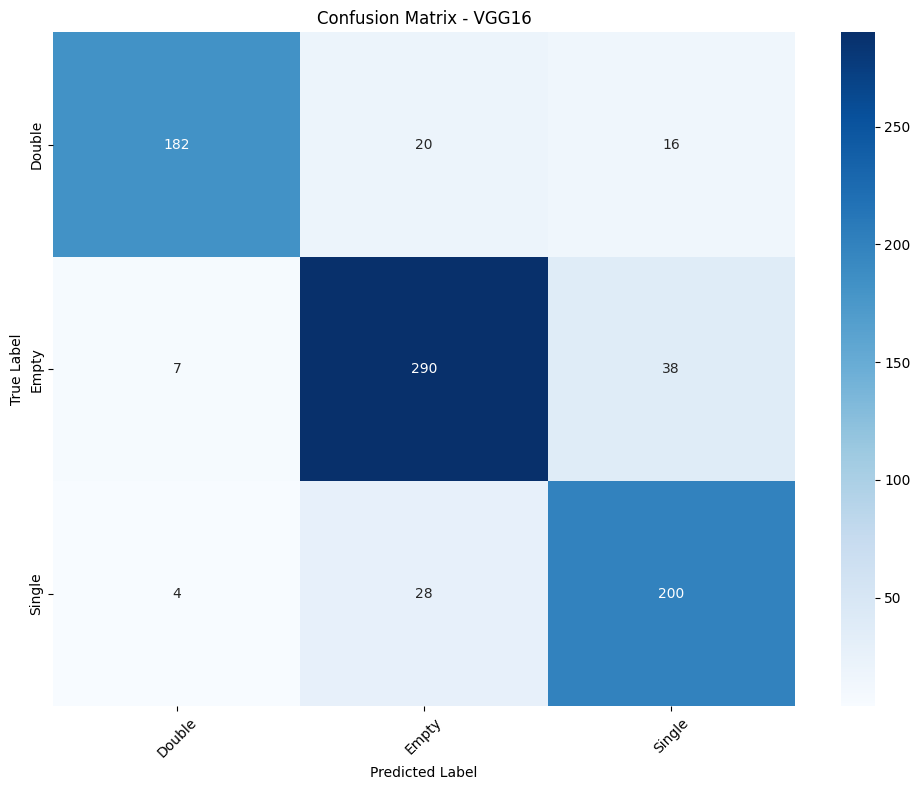

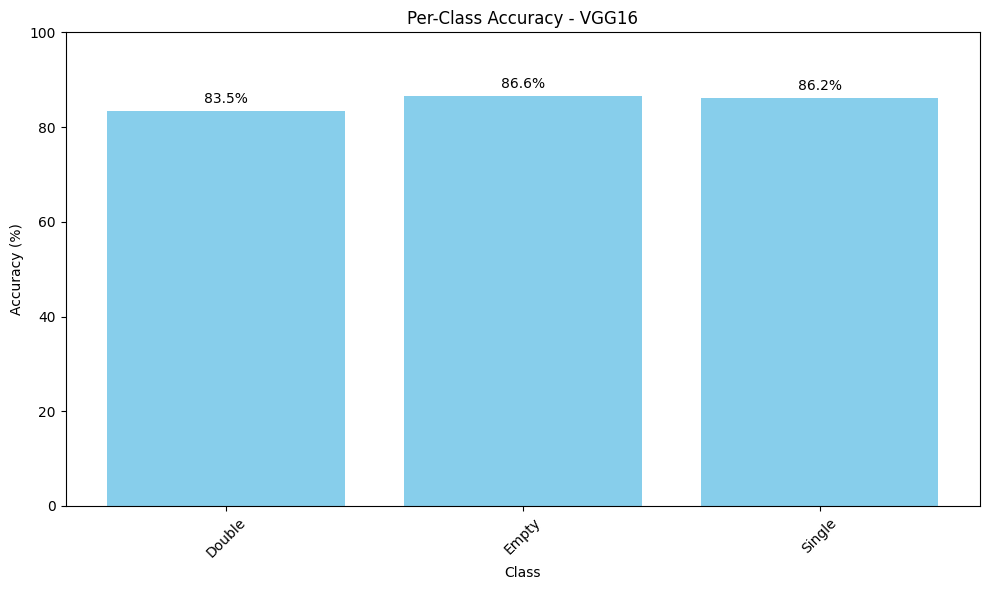


Processing InceptionV3...
Found 2183 images belonging to 3 classes.
Found 545 images belonging to 3 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# -*- coding: utf-8 -*-
"""Optimized Multi-Model CNN with SVM (Fixed).ipynb"""

import tensorflow as tf
from tensorflow.keras.applications import (ResNet50, VGG16, InceptionV3, MobileNetV2)
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import joblib
import os
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
base_dir = '/content/drive/MyDrive/MS 2nd Semester/AAV data/Images/175 mV/1s_segment_raw/train_val_photos'
save_dir = '/'
os.makedirs(save_dir, exist_ok=True)

# Model dictionary
MODEL_DICT = {
    'ResNet50': (ResNet50, preprocess_resnet, (224, 224)),
    'VGG16': (VGG16, preprocess_vgg, (224, 224)),
    'InceptionV3': (InceptionV3, preprocess_inception, (299, 299)),
    'MobileNetV2': (MobileNetV2, preprocess_mobilenet, (224, 224))
}

# List of models to evaluate
models_to_run = ['ResNet50', 'VGG16', 'InceptionV3', 'MobileNetV2']

# Function to extract features efficiently
def extract_features(model, generator, sample_count, batch_size=16):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, *generator.target_size, 3], [None, generator.num_classes])
    ).take(sample_count // batch_size).prefetch(tf.data.AUTOTUNE)

    features = []
    labels = []
    for images, lbls in dataset:
        feats = model(images, training=False)
        features.append(feats.numpy())
        labels.append(lbls.numpy())

    features = np.concatenate(features, axis=0)[:sample_count]
    labels = np.concatenate(labels, axis=0)[:sample_count]
    features_flat = features.reshape((features.shape[0], -1))
    # Convert one-hot encoded labels to multiclass
    labels_multiclass = np.argmax(labels, axis=1)
    return features_flat, labels_multiclass

# Results storage
results_dict = {'Empty': [], 'Single': [], 'Double': [], 'Overall': []}

for model_name in models_to_run:
    print(f"\nProcessing {model_name}...")

    # Get model specifics
    model_fn, preprocess_fn, input_size = MODEL_DICT[model_name]

    # Data generators
    datagen = ImageDataGenerator(preprocessing_function=preprocess_fn, validation_split=0.2)
    train_generator = datagen.flow_from_directory(
        base_dir, target_size=input_size, batch_size=16, class_mode='categorical',
        subset='training', shuffle=False)
    val_generator = datagen.flow_from_directory(
        base_dir, target_size=input_size, batch_size=16, class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = list(train_generator.class_indices.keys())
    num_classes = len(class_names)

    # Load model
    model = model_fn(weights='imagenet', include_top=False, input_shape=(*input_size, 3))

    # Extract features
    train_features, train_labels = extract_features(model, train_generator, 2000)
    val_features, val_labels = extract_features(model, val_generator, 800)

    # Train SVM
    svm = OneVsRestClassifier(LinearSVC(max_iter=1000))
    svm.fit(train_features, train_labels)

    # Save model
    model_path = os.path.join(save_dir, f'{model_name}_svm.joblib')
    joblib.dump(svm, model_path)
    print(f"Saved {model_name} SVM model to {model_path}")

    # Predict
    predicted_labels = svm.predict(val_features)

    # Evaluation
    overall_accuracy = accuracy_score(val_labels, predicted_labels)
    conf_matrix = confusion_matrix(val_labels, predicted_labels)
    per_class_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1) * 100

    # Store results (assuming class order: Empty, Single, Double)
    results_dict['Empty'].append(per_class_accuracy[0] if num_classes > 0 else 0)
    results_dict['Single'].append(per_class_accuracy[1] if num_classes > 1 else 0)
    results_dict['Double'].append(per_class_accuracy[2] if num_classes > 2 else 0)
    results_dict['Overall'].append(overall_accuracy * 100)

    # Print basic metrics
    print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_report(val_labels, predicted_labels, target_names=class_names))

    # Visualizations
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, per_class_accuracy, color='skyblue')
    plt.title(f'Per-Class Accuracy - {model_name}')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%',
                 ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

# Compute statistics
stats = {}
for key in results_dict:
    values = np.array(results_dict[key])
    stats[key] = {
        'Avg': np.mean(values),
        'Max': np.max(values),
        'Min': np.min(values),
        'Eup': np.max(values) - np.mean(values),
        'Edown': np.mean(values) - np.min(values)
    }

# Create and display table
table_data = []
for i, model_name in enumerate(models_to_run):
    row = [f"{results_dict['Empty'][i]:.2f}", f"{results_dict['Single'][i]:.2f}",
           f"{results_dict['Double'][i]:.2f}", f"{results_dict['Overall'][i]:.2f}"]
    table_data.append(row)

for key in stats:
    row = [f"{stats[key]['Avg']:.3f}" if key == 'Avg' else f"{stats[key][key]:.2f}"]
    row.extend([f"{stats[key][key]:.3f}" if key == 'Avg' else f"{stats[key][key]:.2f}" for key in stats][1:])
    table_data.append(row)

df = pd.DataFrame(table_data,
                  index=models_to_run + ['Avg', 'Max', 'Min', 'Eup', 'Edown'],
                  columns=['Empty', 'Single', 'Double', 'Overall'])
print("\nResults Table:")
print(df.to_string())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Processing InceptionV3...
Found 2183 images belonging to 3 classes.
Found 545 images belonging to 3 classes.
Saved InceptionV3 SVM model to /InceptionV3_svm.joblib
Overall Accuracy: 88.79%
Confusion Matrix:
[[202   2  14]
 [  4 299  32]
 [  9  27 196]]
Classification Report:
              precision    recall  f1-score   support

      Double       0.94      0.93      0.93       218
       Empty       0.91      0.89      0.90       335
      Single       0.81      0.84      0.83       232

    accuracy                           0.89       785
   macro avg       0.89      0.89      0.89       785
weighted avg       0.89      0.89      0.89       785



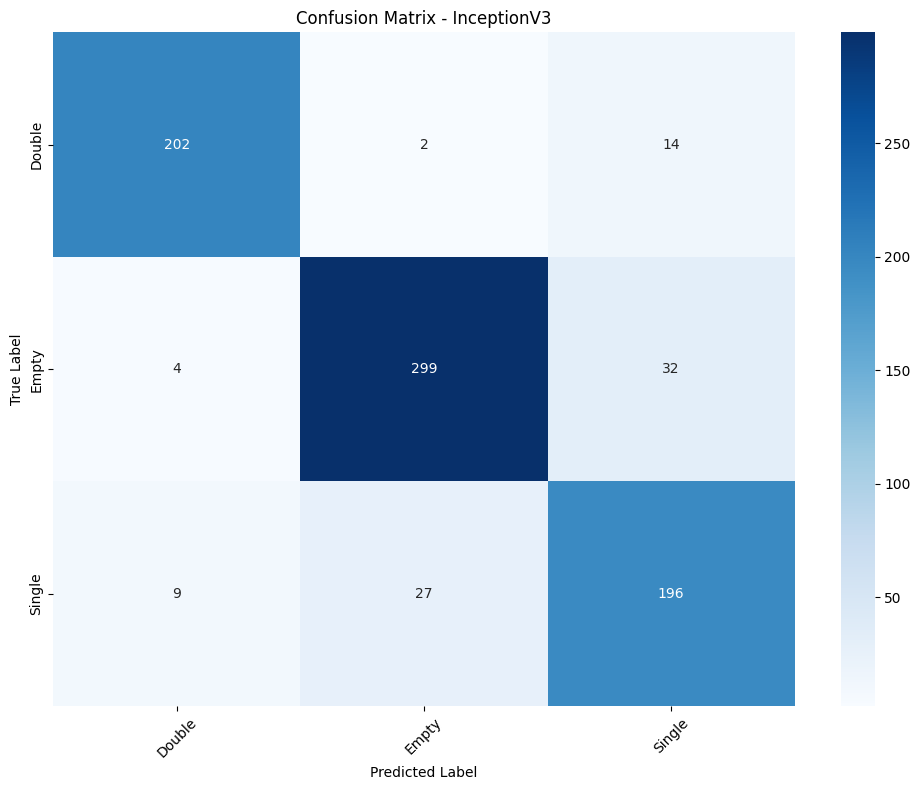

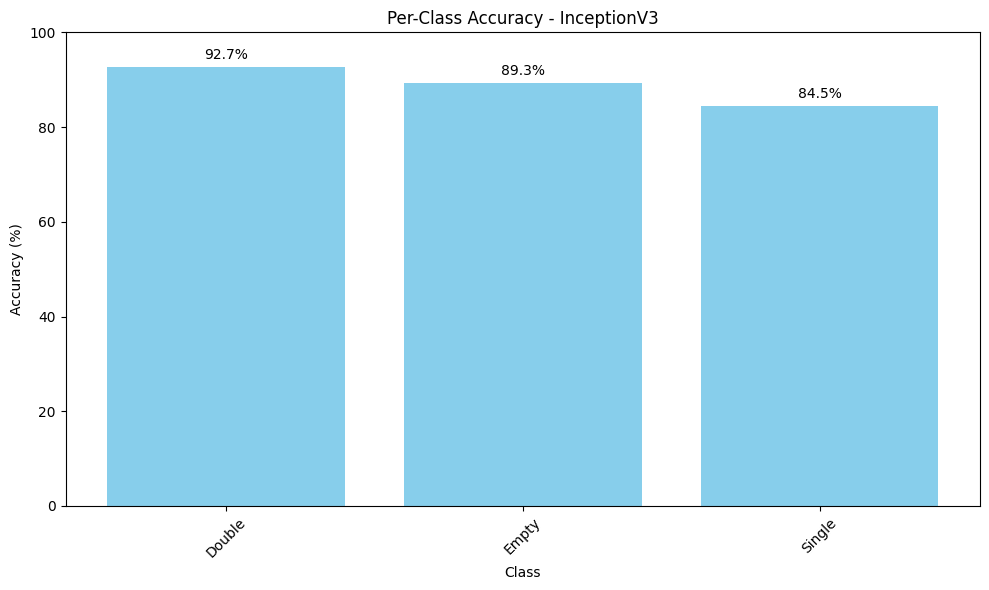


Processing MobileNetV2...
Found 2183 images belonging to 3 classes.
Found 545 images belonging to 3 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Saved MobileNetV2 SVM model to /MobileNetV2_svm.joblib
Overall Accuracy: 87.77%
Confusion Matrix:
[[198  10  10]
 [  3 295  37]
 [ 10  26 196]]
Classification Report:
              precision    recall  f1-score   support

      Double       0.94      0.91      0.92       218
       Empty       0.89      0.88      0.89       335
      Single       0.81      0.84      0.83       232

    accuracy                           0.88       785
   macro avg       0.88      0.88      0.88       785
weighted avg       0.88      0.88      0.88       785



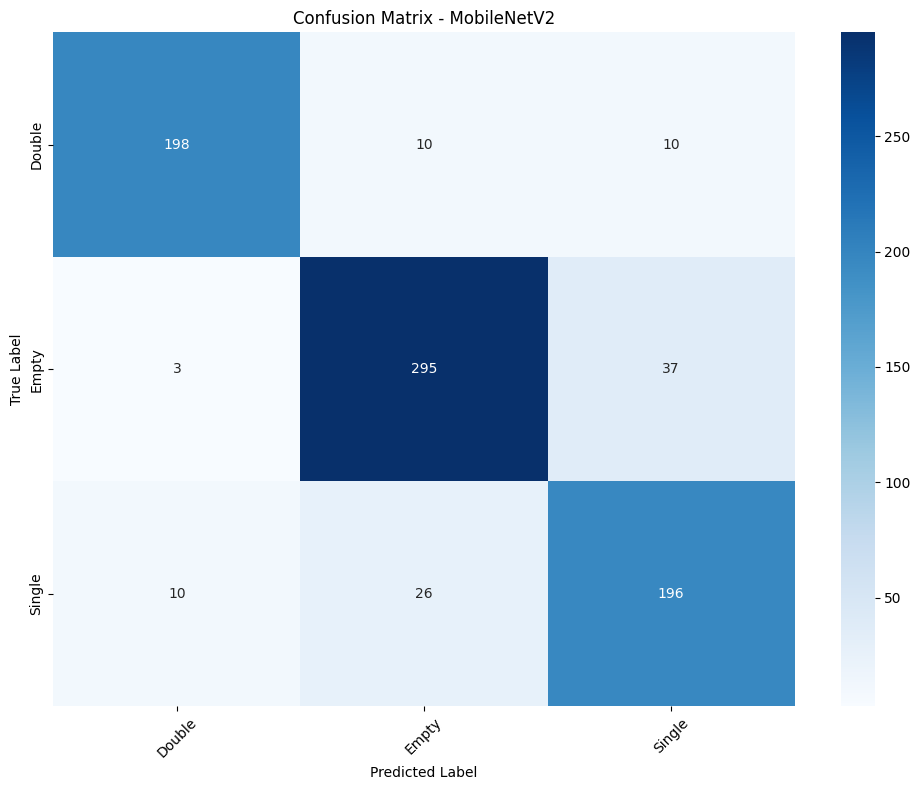

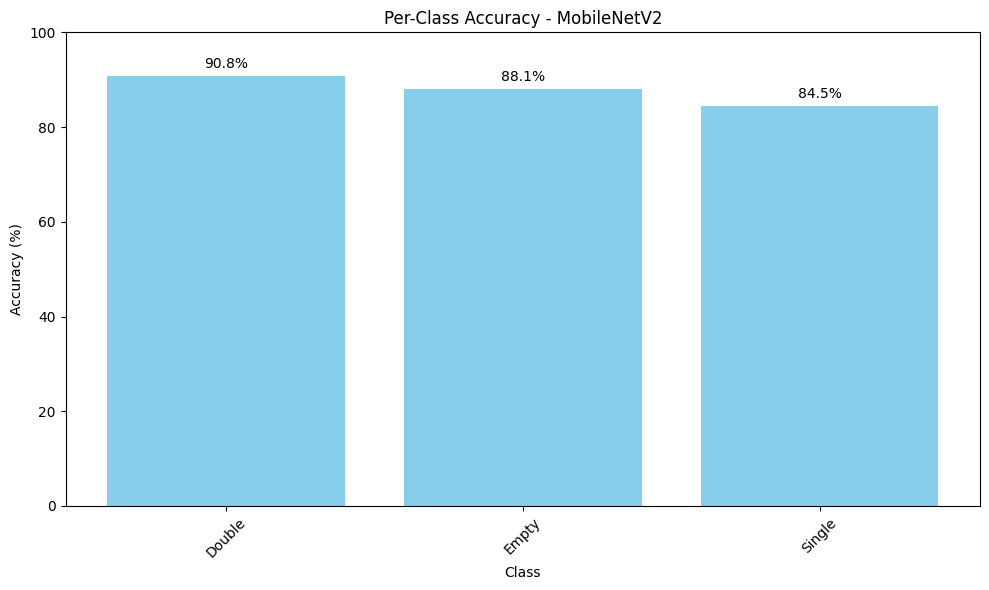

KeyError: 'Empty'

In [ ]:
# -*- coding: utf-8 -*-
"""Restarted Multi-Model CNN with SVM (From InceptionV3).ipynb"""

import tensorflow as tf
from tensorflow.keras.applications import (ResNet50, VGG16, InceptionV3, MobileNetV2)
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import joblib
import os
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
base_dir = '/content/drive/MyDrive/MS 2nd Semester/AAV data/Images/175 mV/1s_segment_raw/train_val_photos'
save_dir = '/'  # Root directory (change if needed)
os.makedirs(save_dir, exist_ok=True)

# Model dictionary
MODEL_DICT = {
    'ResNet50': (ResNet50, preprocess_resnet, (224, 224)),
    'VGG16': (VGG16, preprocess_vgg, (224, 224)),
    'InceptionV3': (InceptionV3, preprocess_inception, (299, 299)),
    'MobileNetV2': (MobileNetV2, preprocess_mobilenet, (224, 224))
}

# List of models to evaluate (starting from InceptionV3)
models_to_run = ['InceptionV3', 'MobileNetV2']

# Function to extract features efficiently
def extract_features(model, generator, sample_count, batch_size=16):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, *generator.target_size, 3], [None, generator.num_classes])
    ).take(sample_count // batch_size).prefetch(tf.data.AUTOTUNE)

    features = []
    labels = []
    for images, lbls in dataset:
        feats = model(images, training=False)
        features.append(feats.numpy())
        labels.append(lbls.numpy())

    features = np.concatenate(features, axis=0)[:sample_count]
    labels = np.concatenate(labels, axis=0)[:sample_count]
    features_flat = features.reshape((features.shape[0], -1))
    # Convert one-hot encoded labels to multiclass
    labels_multiclass = np.argmax(labels, axis=1)
    return features_flat, labels_multiclass

# Results storage (initialize with previous results if available, or start fresh)
results_dict = {
    'Empty': [],  # Add previous results here if you have them: e.g., [44.61, 84.80]
    'Single': [],  # e.g., [97.84, 83.62]
    'Double': [],  # e.g., [100.00, 93.64]
    'Overall': []  # e.g., [78.39, 86.08]
}

# Optionally, load previous results if you saved them (e.g., from a file)
# For now, assuming we start fresh for InceptionV3 and MobileNetV2

for model_name in models_to_run:
    print(f"\nProcessing {model_name}...")

    # Get model specifics
    model_fn, preprocess_fn, input_size = MODEL_DICT[model_name]

    # Data generators
    datagen = ImageDataGenerator(preprocessing_function=preprocess_fn, validation_split=0.2)
    train_generator = datagen.flow_from_directory(
        base_dir, target_size=input_size, batch_size=16, class_mode='categorical',
        subset='training', shuffle=False)
    val_generator = datagen.flow_from_directory(
        base_dir, target_size=input_size, batch_size=16, class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = list(train_generator.class_indices.keys())
    num_classes = len(class_names)

    # Load model
    model = model_fn(weights='imagenet', include_top=False, input_shape=(*input_size, 3))

    # Extract features
    train_features, train_labels = extract_features(model, train_generator, 2000)
    val_features, val_labels = extract_features(model, val_generator, 800)

    # Train SVM
    svm = OneVsRestClassifier(LinearSVC(max_iter=1000))
    svm.fit(train_features, train_labels)

    # Save model
    model_path = os.path.join(save_dir, f'{model_name}_svm.joblib')
    joblib.dump(svm, model_path)
    print(f"Saved {model_name} SVM model to {model_path}")

    # Predict
    predicted_labels = svm.predict(val_features)

    # Evaluation
    overall_accuracy = accuracy_score(val_labels, predicted_labels)
    conf_matrix = confusion_matrix(val_labels, predicted_labels)
    per_class_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1) * 100

    # Store results (assuming class order: Empty, Single, Double)
    results_dict['Empty'].append(per_class_accuracy[0] if num_classes > 0 else 0)
    results_dict['Single'].append(per_class_accuracy[1] if num_classes > 1 else 0)
    results_dict['Double'].append(per_class_accuracy[2] if num_classes > 2 else 0)
    results_dict['Overall'].append(overall_accuracy * 100)

    # Print basic metrics
    print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_report(val_labels, predicted_labels, target_names=class_names))

    # Visualizations
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, per_class_accuracy, color='skyblue')
    plt.title(f'Per-Class Accuracy - {model_name}')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%',
                 ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

# Compute statistics
stats = {}
for key in results_dict:
    values = np.array(results_dict[key])
    stats[key] = {
        'Avg': np.mean(values),
        'Max': np.max(values),
        'Min': np.min(values),
        'Eup': np.max(values) - np.mean(values),
        'Edown': np.mean(values) - np.min(values)
    }

# Create and display table
table_data = []
for i, model_name in enumerate(models_to_run):
    row = [f"{results_dict['Empty'][i]:.2f}", f"{results_dict['Single'][i]:.2f}",
           f"{results_dict['Double'][i]:.2f}", f"{results_dict['Overall'][i]:.2f}"]
    table_data.append(row)

for key in stats:
    row = [f"{stats[key]['Avg']:.3f}" if key == 'Avg' else f"{stats[key][key]:.2f}"]
    row.extend([f"{stats[key][key]:.3f}" if key == 'Avg' else f"{stats[key][key]:.2f}" for key in stats][1:])
    table_data.append(row)

df = pd.DataFrame(table_data,
                  index=models_to_run + ['Avg', 'Max', 'Min', 'Eup', 'Edown'],
                  columns=['Empty', 'Single', 'Double', 'Overall'])
print("\nResults Table:")
print(df.to_string())